# Cell Tracking (Project 6)

**Group 12: Maximilian Karhausen, Johannes Simon**

**Background:** When testing a pharmacological drug onto cells, the effect on the cell population growth and 
overall phenotype is usually assessed by a single snapshot image. While these population and 
time-averaged measurements can highlight big scale effects between cell populations and 
conditions, they are an indirect measure of responses to chemotherapeutic drugs. Another 
approach is to record long videos of these cell populations while subjected to the drugs. These 
live observations are more accurate in capturing the proliferation behavior than standard 
approaches. Manual tracking of each single cell in the visual field is very time-consuming.

**Approach:** Given pre-detected cancer cells (in COCO format), we investigate suitable methods to match detections across frames (tracking). To do this, we compare the tracking methods SORT and DeepSORT with each other.

In [1]:
# ensuring that plots are rendered inline
%matplotlib inline

# Get all necessary imports
import json
from pathlib import Path
import cv2
# import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from sort.sort import *
import numpy as np
import motmetrics as mm
from PIL import Image

## Part 1: Load the dataset and classify the cells

In [2]:
# Initialize local paths
# Dataset path
# Hint: (change to "/scratch/cv-course/jsimon10/dataset_jpg/dataset" when working on RAMSES)
DATASET_DIR = Path("dataset_jpg/dataset")
# Annotations file path
ANN_FILE = DATASET_DIR / "annotations.json"
# Create folder for cropped cells, needed later to train appearance model for DeepSORT
CROP_DIR = Path("cell_crops")
CROP_DIR.mkdir(exist_ok=True)

In [3]:
# Load the COCO annotations from the annotations.json file
with ANN_FILE.open("r") as f:
    coco = json.load(f)
# Get category name by their ID
cat_name_by_id = {cat["id"]: cat["name"] for cat in coco["categories"]}
# Group all annotations by their image ID to find all cells for each image more easily
annots_by_img = {}
for ann in coco["annotations"]:
    annots_by_img.setdefault(ann["image_id"], []).append(ann)
# Group all images by their ID to find them more faster
img_by_id = {}
for img in coco["images"]:
    img_by_id[img["id"]] = img
# Print summary info on the dataset once loaded
print("Loaded dataset with:")
print(f"  - {len(coco['images'])} images")
print(f"  - {len(coco['annotations'])} annotations")
print(f"  - {len(coco['categories'])} categories:")
for cat_id, cat_name in cat_name_by_id.items():
    print(f"    ID {cat_id}: {cat_name}")

Loaded dataset with:
  - 40350 images
  - 2204912 annotations
  - 2 categories:
    ID 1: living_cell
    ID 2: dead_cell


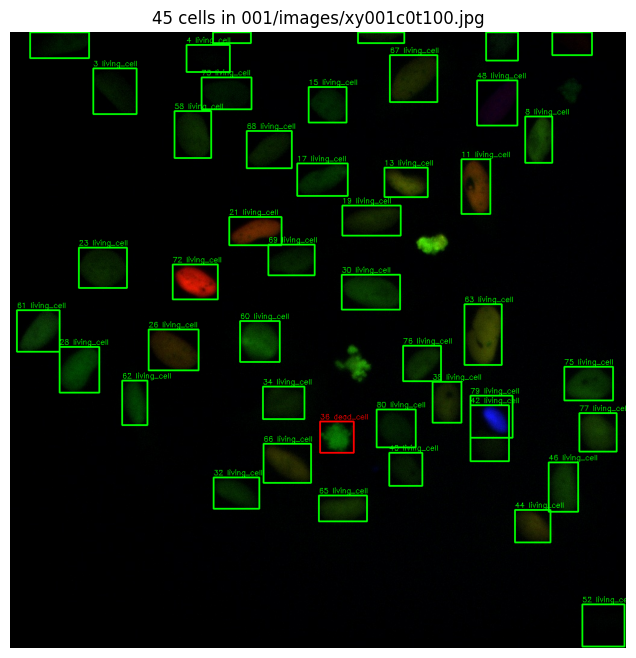

In [4]:
%matplotlib inline
# Get an image by an selected index for visualization
img_example = img_by_id[100] # For testing, only index of 0-449 works. Original dataset: up to 40349
# Get the path to the image
img_path = DATASET_DIR / img_example["file_name"]
# Raise an error if image does not exist
if not img_path.exists():
    raise FileNotFoundError(f"Image file not found: {img_path}")
# Load the image and turn from BGR to RGB
img_rgb = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
# Get annotations for the selected image
annots = annots_by_img.get(img_example["id"], [])
# Apply different colors for bounding boxes of different classes
bbox_color_map = {
    "living_cell": (0, 255, 0),     # green for living cell
    "dead_cell": (255, 0, 0),     # red for dead cell
}
# Draw bounding boxes based on annotations
for i, ann in enumerate(annots):
    # Get center x and y coordinates of the bounding box with width and height
    x_center, y_center, width, height = ann["bbox"]
    # For correct drawing (and SORT later), convert center-based x and y coordinates to top-left
    x, y = x_center - width / 2, y_center - height / 2
    # For correct drawing, turn float values to int values - OpenCV expects int values
    x_draw, y_draw, width_draw, height_draw = int(x), int(y), int(width), int(height)
    # Get the classified category
    cat_id = ann["category_id"]
    # Get the respective category name
    cat_name = cat_name_by_id.get(cat_id, "unknown") # Edge case: If annotation without category exist, label as "unknown"
    # Construct label with cell ID and category name, e.g. 30 living_cell
    label = f"{ann['cell_id']} {cat_name}"
    # Get the respective color of bounding box
    color = bbox_color_map.get(cat_name, (255, 255, 255)) # Edge case: If annotation without category exist, color white
    # Draw the bounding boxes and the text with the classified category 
    cv2.rectangle(img_rgb, (x_draw, y_draw), (x_draw + width_draw, y_draw + height_draw), color, 2)
    cv2.putText(img_rgb, label, (x_draw, y_draw - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
# Show classification result
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"{len(annots)} cells in {img_example['file_name']}")
plt.show()

## Part 2: Prepare the data to train the appearance model of DeepSORT

In [5]:
# Get all folder names in a sorted list
#all_folders = sorted([f.name for f in DATASET_DIR.iterdir() if f.is_dir()])
all_folders = ["001", "002", "003"] # REMOVE THIS FOR ORIGINAL DATASET
# Ensure reproducibility with same sequence of random folders
random.seed(30)
# Shuffle the list of folders randomly
random.shuffle(all_folders)
# Split the folders by 80% for training (with cropped cells) and 20% testing (for tracking)
split_idx = int(0.8 * len(all_folders))
train_folders = set(all_folders[:split_idx])
test_folders = set(all_folders[split_idx:])
# Crop cells for all annotations
for ann in coco["annotations"]:
    # Get image from current annotation
    img = img_by_id[ann["image_id"]]
    # Get image path of given image
    img_path = DATASET_DIR / img["file_name"]
    # Get ID of folder, e.g. 001
    folder = Path(img["file_name"]).parts[0]
    # Skip folders that are not selected for training
    if folder not in train_folders:
        continue
    # Load the image in BGR format
    img_bgr = cv2.imread(str(img_path))
    # Get center x and y coordinates of the bounding box with width and height
    x_center, y_center, width, height = ann["bbox"]
    # Get image bounds of the cell
    x0, y0, x1, y1 = int(x_center - width / 2), int(y_center - height / 2), int(x_center + width / 2), int(y_center + height / 2)
    # Get actual height and width of the original image
    img_height, img_width = img_bgr.shape[:2]
    # Skip all edge-cut cells
    if (x0 <= 0 or y0 <= 0 or x1 >= img_width or y1 >= img_height):
        continue
    # Define unique ID as video ID and cell ID for folder, e.g. 001_001
    id = f"{ann['video_id']:03d}_{ann['cell_id']:03d}"
    # Get the classified category
    cat_id = ann["category_id"]
    # Get the respective category name
    cat_name = cat_name_by_id.get(cat_id, "unknown") # Edge case: If annotation without category exist, label as "unknown"
    # Create folder for given cell ID by video ID to save cropped cells
    output_dir = CROP_DIR / id
    output_dir.mkdir(parents=True, exist_ok=True)
    # Save cropped cell with annotation ID and classified category, e.g. 0000002_living_cell.jpg
    output_img_name = f"{ann['id']:07d}_{cat_name}.jpg"
    # Specify path of cropped cell image
    output_img_path = output_dir / output_img_name
    # Crop the original image to constructed bounding box with the cell and write it to given path
    cv2.imwrite(str(output_img_path), img_bgr[y0:y1, x0:x1])
print("Successfully cropped cells for training the appearance model of DeepSORT")

Successfully cropped cells for training the appearance model of DeepSORT


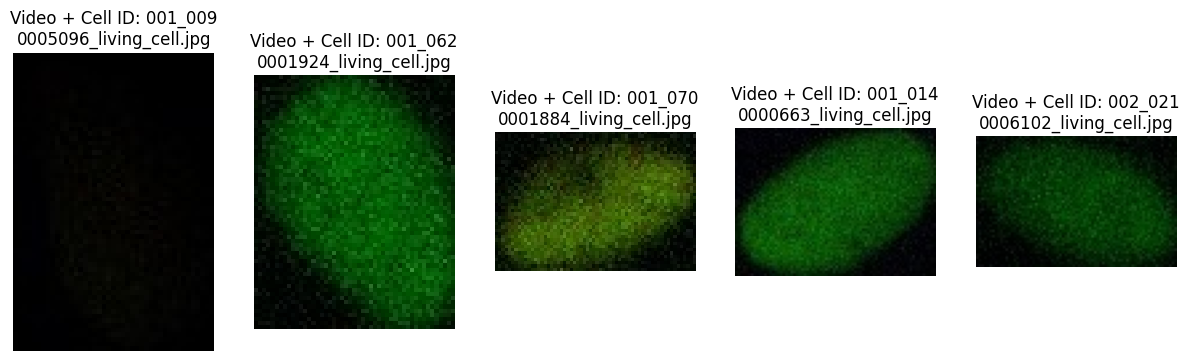

In [6]:
%matplotlib inline
# Collect all cropped cell image paths
crop_paths = list(CROP_DIR.rglob("*.jpg"))
# Randomly pick five example images
crop_examples = random.sample(crop_paths, 5)
# Plot the five images
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(crop_examples):
    # Load the current image
    img = cv2.imread(str(img_path))
    # Turn the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Create five consecutive subplots
    plt.subplot(1, 5, i+1)
    plt.imshow(img_rgb)
    # Print folder and image name
    plt.title("Video + Cell ID: " + img_path.parts[-2] + "\n" + img_path.name)
    plt.axis('off')
plt.show()

## Part 3: Train the appearance model of DeepSORT

In [ ]:
# Initialize different values for hyperparameters for in-depth analysis
batch_sizes = [4, 8, 16, 32, 64] # Default: 32
lrs = [0.0001, 0.001, 0.01] # Default: 0.001
optimizer = ["sgd", "nesterov", "adam"] # Default: SGD

In [ ]:
# Train the appearance model through train.py of DeepSORT with different learning rates and optimizers
# Grid Search for two hyperparameters that interact strongly with each other; investigate impact of hyperparameters and find best performing pair
for lr in lrs:
    for opt in optimizer:
        print("---------------------------------------------------------------------------------")
        print(f"Model with batch size: {32}, epochs: {40}, learning rate: {lr}, optimizer: {opt}")
        # Initialize model name for train.jpg
        model_name = f"{opt}_lr{lr}_batch{32}"
        # Train the model
        print(model_name)
        !python deep_sort_pytorch/deep_sort/deep/train.py --data-dir cell_crops --lr {lr} --optimizer {opt} --model_name {model_name}

In [ ]:
# Manually select the best values for the learning rate and optimizer
best_lr = 0.001
best_opt = "sgd"

In [ ]:
# Train the appearance model through train.py of DeepSORT with different batch sizes
# Greedy Search for batch size with best performing learning rate + optimizer pair; investigate impact of batch size and find best performing one
for size in batch_sizes:
    print("---------------------------------------------------------------------------------")
    print(f"Model with batch size: {size}, epochs: {40}, learning rate: {best_lr}, optimizer: {best_opt}")
    # Initialize model name for train.jpg
    model_name = f"{best_opt}_lr{best_lr}_batch{size}"
    # Train the model
    !python deep_sort_pytorch/deep_sort/deep/train.py --data-dir cell_crops --batch_size {size} --lr {best_lr} --optimizer {best_opt} --model_name {model_name}

In [ ]:
# Manually select the best value for the batch size
best_batch_size = 32

In [ ]:
# Train the final appearance model with the best performing hyperparameters
# Use 60 epochs, find optimal epoch count and use that model for tracking with DeepSORT
print(f"Final model with batch size: {best_batch_size}, epochs: {60}, learning rate: {best_lr}, optimizer: {best_opt}")
# Initialize model name for train.jpg
model_name = f"final_version_{best_opt}_lr{best_lr}_batch{best_batch_size}"
# Train the model
!python deep_sort_pytorch/deep_sort/deep/train.py --data-dir cell_crops --epochs 60 --batch_size {best_batch_size} --lr {best_lr} --optimizer {best_opt} --model_name {model_name}

In [ ]:
# Visualize the automatically generated train + val loss plot
train_val_img = mpimg.imread(f"deep_sort_pytorch/deep_sort/deep/train_final_version_{best_opt}_lr{best_lr}_batch{best_batch_size}.jpg")
plt.imshow(train_val_img)
plt.axis('off')
plt.show()

## Part 4: SORT

### Evaluating SORT

In [20]:
# --- Initialize MOTAccumulator ---
acc = mm.MOTAccumulator(auto_id=False)

# Store the image here that we want to visualize
EXAMPLE_IMAGE_ID_TO_VISUALIZE = 447
example_frame_data = {
    'image_path': None,
    'gt_bboxes': [],
    'gt_ids': [],
    'gt_categories': [],
    'pred_bboxes': [],
    'pred_ids': []
}

# --- Main Evaluation Loop ---
all_tracked_results = []

# Filter images belonging to the test folders and sort them by frame_id
video_image_infos = []
for video_name in test_folders:
    # Get all image_ids belonging to this video
    # Efficiently gather image info for the current video from img_by_id
    current_video_images = [
        img_info for img_id, img_info in img_by_id.items()
        if img_info['file_name'].startswith(video_name + '/')
    ]
    current_video_images.sort(key=lambda x: x['frame_id']) # Sort by frame_id
    video_image_infos.extend(current_video_images)

# Group video_image_infos by video_name to reset tracker per video
grouped_video_image_infos = {}
for img_info in video_image_infos:
    video_name = img_info['file_name'].split('/')[0] # Extract video name from file_name
    grouped_video_image_infos.setdefault(video_name, []).append(img_info)

for video_name in test_folders: # Iterate over test_folders to maintain per-video processing
    print(f"\nProcessing video: {video_name}")
    tracker = Sort() # Reset tracker for each new video sequence

    current_video_frames = grouped_video_image_infos.get(video_name, [])

    for img_info in current_video_frames:
        frame_id_in_coco = img_info["id"]
        frame_number_in_video = img_info["frame_id"]
        file_name = img_info["file_name"]
        full_image_path = DATASET_DIR / file_name

        # --- Get Ground Truth for current frame ---
        # Use your preprocessed annots_by_img
        raw_gt_annotations = annots_by_img.get(frame_id_in_coco, [])

        gt_data_unique = {} # {cell_id: (bbox_xyxy, category_id)}
        for ann in raw_gt_annotations:
            bbox_xywh = ann['bbox'] # [x_center, y_center, width, height]
            cell_id = ann['cell_id']
            category_id = ann['category_id']
            x_c, y_c, w, h = bbox_xywh
            x1, y1, x2, y2 = x_c - w/2, y_c - h/2, x_c + w/2, y_c + h/2
            gt_data_unique[cell_id] = ([x1, y1, x2, y2], category_id)

        gt_ids = list(gt_data_unique.keys())
        gt_bboxes_xyxy = [gt_data_unique[id_][0] for id_ in gt_ids]
        gt_categories = [gt_data_unique[id_][1] for id_ in gt_ids] # Get categories in order

        # --- Prepare Detections for SORT input ---
        detections_for_sort = []
        for ann in raw_gt_annotations: # Iterate over raw annotations for SORT input
            bbox_xywh = ann['bbox']
            x_c, y_c, w, h = bbox_xywh
            x1, y1, x2, y2 = x_c - w/2, y_c - h/2, x_c + w/2, y_c + h/2
            detections_for_sort.append([x1, y1, x2, y2, 1.0])

        detections_for_sort = np.array(detections_for_sort)
        if detections_for_sort.size == 0:
            detections_for_sort = np.empty((0, 5))

        tracked_objects = tracker.update(detections_for_sort)

        # --- Process Tracker Output for motmetrics ---
        pred_bboxes_xyxy = []
        pred_ids = []
        if tracked_objects.size > 0:
            pred_bboxes_xyxy = tracked_objects[:, :4].tolist()
            pred_ids = tracked_objects[:, 4].astype(int).tolist()

        # --- Create IoU matrix (distance = 1 - IoU) ---
        def calculate_iou(boxA, boxB):
            xA = max(boxA[0], boxB[0])
            yA = max(boxA[1], boxB[1])
            xB = min(boxA[2], boxB[2])
            yB = min(boxA[3], boxB[3])

            interArea = max(0, xB - xA) * max(0, yB - yA)
            boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
            boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
            union_area = boxAArea + boxBArea - interArea

            iou = interArea / float(union_area) if union_area > 0 else 0
            return iou

        iou_matrix = np.full((len(gt_ids), len(pred_ids)), np.nan)
        if len(gt_ids) > 0 and len(pred_ids) > 0:
            for i, gt_box in enumerate(gt_bboxes_xyxy):
                for j, pred_box in enumerate(pred_bboxes_xyxy):
                    iou_score = calculate_iou(gt_box, pred_box)
                    iou_matrix[i, j] = 1 - iou_score

        # --- Update the MOTAccumulator ---
        acc.update(
            gt_ids,
            pred_ids,
            iou_matrix,
            frameid=frame_id_in_coco
        )

        print(f"Video {video_name}, Frame {frame_number_in_video} (Image ID: {frame_id_in_coco}): GT objects {len(gt_ids)}, Predicted objects {len(pred_ids)}")

        # --- Visualize first image ---
        if EXAMPLE_IMAGE_ID_TO_VISUALIZE == frame_id_in_coco and example_frame_data['image_path'] is None:
            example_frame_data['image_path'] = full_image_path
            example_frame_data['gt_bboxes'] = gt_bboxes_xyxy
            example_frame_data['gt_ids'] = gt_ids
            example_frame_data['gt_categories'] = gt_categories
            example_frame_data['pred_bboxes'] = pred_bboxes_xyxy
            example_frame_data['pred_ids'] = pred_ids

        # --- Store results for MOTChallenge output (optional) ---
        for obj in tracked_objects:
            x1, y1, x2, y2, track_id = obj
            x, y, w, h = x1, y1, x2 - x1, y2 - y1
            all_tracked_results.append([frame_number_in_video, int(track_id), x, y, w, h, 1.0, -1, -1, -1])


Processing video: 003
Video 003, Frame 0 (Image ID: 301): GT objects 29, Predicted objects 29
Video 003, Frame 1 (Image ID: 302): GT objects 29, Predicted objects 29
Video 003, Frame 2 (Image ID: 303): GT objects 29, Predicted objects 29
Video 003, Frame 3 (Image ID: 304): GT objects 30, Predicted objects 27
Video 003, Frame 4 (Image ID: 305): GT objects 31, Predicted objects 29
Video 003, Frame 5 (Image ID: 306): GT objects 31, Predicted objects 28
Video 003, Frame 6 (Image ID: 307): GT objects 31, Predicted objects 29
Video 003, Frame 7 (Image ID: 308): GT objects 32, Predicted objects 29
Video 003, Frame 8 (Image ID: 309): GT objects 32, Predicted objects 29
Video 003, Frame 9 (Image ID: 310): GT objects 32, Predicted objects 30
Video 003, Frame 10 (Image ID: 311): GT objects 33, Predicted objects 29
Video 003, Frame 11 (Image ID: 312): GT objects 33, Predicted objects 30
Video 003, Frame 12 (Image ID: 313): GT objects 33, Predicted objects 30
Video 003, Frame 13 (Image ID: 314): G

### Compute and print Metrics

In [21]:
# --- Compute and Print Metrics ---
mh = mm.metrics.create()

summary = mh.compute(
    acc,
    metrics=['mota', 'idf1', 'num_switches', 'recall', 'precision', 'num_misses', 'num_false_positives'],
    name='SORT_Tracker_Evaluation'
)

print("\n--- MOTMetrics Summary ---")
print(mm.io.render_summary(summary, formatters=mh.formatters, namemap=mm.io.motchallenge_metric_names))

# Optional: Save MOTChallenge results
# For MOTChallenge, you'd typically save one file per video.
# You'd need to group `all_tracked_results` by video_name if you want to save them per video.
# For simplicity, here's how to save all results to one file (not typical MOTChallenge practice):
# output_file = "sort_tracking_results.txt"
# np.savetxt(output_file, np.array(all_tracked_results), fmt='%i,%i,%.2f,%.2f,%.2f,%.2f,%.2f,%i,%i,%i')
# print(f"\nSaved all tracked results to {output_file}")


--- MOTMetrics Summary ---
                         MOTA  IDF1 IDs  Rcll   Prcn  FN FP
SORT_Tracker_Evaluation 90.7% 87.0%  76 91.8% 100.0% 543  0


### Visualization

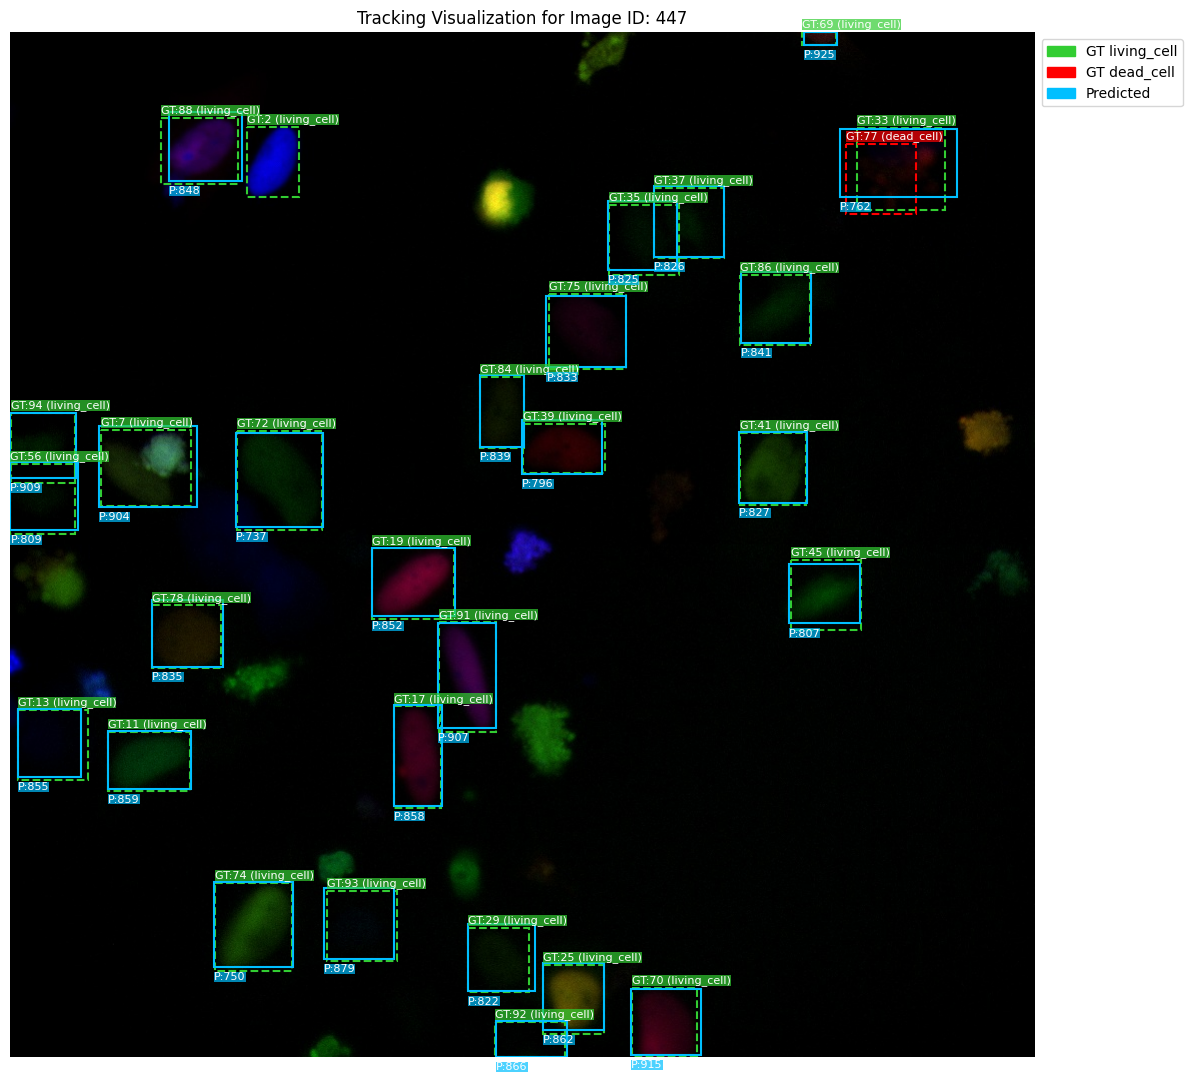

In [22]:
# --- Define colors for living and dead cells ---
# Using specific colors, and mapping category_id to color and name for easy lookup
CATEGORY_COLORS = {
    1: {'color': 'limegreen', 'name': cat_name_by_id.get(1, 'Living Cell')}, # Using cat_name_by_id
    2: {'color': 'red', 'name': cat_name_by_id.get(2, 'Dead Cell')}      # Using cat_name_by_id
}
PREDICTED_COLOR = 'deepskyblue'

if example_frame_data['image_path'] is not None:
    try:
        img = Image.open(example_frame_data['image_path']).convert("RGB")
    except FileNotFoundError:
        print(f"Error: Image file not found at {example_frame_data['image_path']}")
        print("Please ensure DATASET_DIR and file_name paths are correct.")
    except Exception as e:
        print(f"An error occurred loading the image: {e}")
    else:
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.imshow(img)
        ax.axis('off')

        # Draw Ground Truth Bounding Boxes
        for i, (x1, y1, x2, y2) in enumerate(example_frame_data['gt_bboxes']):
            gt_id = example_frame_data['gt_ids'][i]
            gt_category_id = example_frame_data['gt_categories'][i]

            # Get color and name based on category_id
            color_info = CATEGORY_COLORS.get(gt_category_id, {'color': 'gray', 'name': 'Unknown'})
            box_color = color_info['color']
            category_name = color_info['name']

            width = x2 - x1
            height = y2 - y1

            rect = patches.Rectangle((x1, y1), width, height,
                                     linewidth=1.5, edgecolor=box_color, facecolor='none', linestyle='--')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f'GT:{gt_id} ({category_name})',
                    bbox=dict(facecolor=box_color, alpha=0.7, edgecolor='none', pad=0),
                    color='white', fontsize=8)

        # Draw Predicted (Tracked) Bounding Boxes
        for i, (x1, y1, x2, y2) in enumerate(example_frame_data['pred_bboxes']):
            pred_id = example_frame_data['pred_ids'][i]
            width = x2 - x1
            height = y2 - y1

            rect = patches.Rectangle((x1, y1), width, height,
                                     linewidth=1.5, edgecolor=PREDICTED_COLOR, facecolor='none', linestyle='-')
            ax.add_patch(rect)
            ax.text(x1, y1 + height + 5, f'P:{pred_id}',
                    bbox=dict(facecolor=PREDICTED_COLOR, alpha=0.7, edgecolor='none', pad=0),
                    color='white', fontsize=8, verticalalignment='top')

        # Create a legend
        legend_patches = [
            patches.Patch(color=CATEGORY_COLORS[1]['color'], label=f"GT {CATEGORY_COLORS[1]['name']}"),
            patches.Patch(color=CATEGORY_COLORS[2]['color'], label=f"GT {CATEGORY_COLORS[2]['name']}"),
            patches.Patch(color=PREDICTED_COLOR, label="Predicted")
        ]
        ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)


        plt.title(f"Tracking Visualization for Image ID: {EXAMPLE_IMAGE_ID_TO_VISUALIZE}")
        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show()
else:
    print("\nSkipping visualization: No images with annotations found to select a random example or image path not found.")